# Figure 1

Simulated precipitation distributions. (a--c) Zonal average precipitation and (d--f) histogram of tropical marine precipitation for (left-to-right) aquaplanet experiments, AMIP experiments, and CESM2 cloud-locking experiments. Colors are as noted in legends, with solid curves showing the control simulations and dashed curves showing the LWoff or cloud-locked simulations.

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from cycler import cycler
import palettable
import colorcet as cc

In [2]:
def _load(p):
    if not isinstance(p, list):
        p = [p]
    if len(p) == 1:
        ds = xr.open_dataset(p[0])
    else:
        ds = xr.open_mfdataset(p)
    dv = ds.data_vars
    if 'pr' in dv:
        return dv['pr']
    elif 'PRECT' in dv:
        return dv['PRECT']
    else:
        raise IOError("Could not find pr or PRECT")

In [3]:
def mm2inches(x):
    return x * 0.0393701

In [4]:
#
# We have 3 pieces of information, each in its own file: zonal mean, quantiles, histogram
#
region_string = "tropical" # "nh_extratropics"  #  
p0 = Path("/Volumes/Jedha/")
p1 = p0 / "CMIP6"
p2 = p0 / "cloud_locking"

models = {"CESM2": ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff', 'f-cntl', 'f-lock', 'c-cntl', 'c-lock'),
         'CNRM-CM6-1': ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'),
         'IPSL-CM6A-LR': ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'),
         'HadGEM3-GC31-LL': ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'),
         'MRI-ESM2-0': ('amip', 'amip-lwoff'),
         }


locking = {'f-cntl': 'F1850JJB_c201_CTL',
           'f-lock': 'F1850JJB_c201_CLOCK', 
           'c-cntl': 'B1850_c201_CTL',
           'c-lock': 'B1850_c201_CLOCK'}

use_member = {}
for m in models:
    if m == 'CNRM-CM6-1':
        use_member[m] = 'r1i1p1f2'
    elif m == 'HadGEM3-GC31-LL':
        use_member[m] = '*'
    else:
        use_member[m] = 'r1i1p1f1'

ZM = {}  # zonal mean
Q = {}  # quantiles
H = {}  # histogram
for m in models:
    ZM[m] = {}
    Q[m] = {}
    H[m] = {}
    for ex in models[m]:
        if ex in ('aqua-control', 'aqua-control-lwoff', 'amip', 'amip-lwoff'):
            ZM[m][ex] = (86400.) * _load(
                sorted(
                    list(
                        (p1 / "zonal_mean").glob(f'pr_day_{m}_{ex}_{use_member[m]}_ocean.nc'))
                )
            )
            Q[m][ex] = (86400.) * _load( sorted(
                list(
                    (p1 / "quantiles").glob(f'pr_day_{m}_{ex}_{use_member[m]}_{region_string}_ocean.nc'))
                )
            )
            
            H[m][ex] = _load(sorted(list((p1 / "histograms").glob(f'pr_day_{m}_{ex}_{use_member[m]}_{region_string}_ocean.nc'))))
        else:
            # case for locking
            ZM[m][ex] = (86400.*1000.) * _load(p2 / "zonal_mean" / f'PRECT_day_{locking[ex]}_ocean.nc')
            Q[m][ex] = (86400.*1000.) * _load(p2 / "quantiles" / f'PRECT_day_{locking[ex]}_{region_string}_ocean.nc')
            H[m][ex] = _load(p2 / "histograms" / f'PRECT_day_{locking[ex]}_{region_string}_ocean.nc')


            
# pcolors = palettable.colorbrewer.qualitative.Paired_12.mpl_colors
# pcolors = palettable.tableau.Tableau_20_r.mpl_colors
# model_colors = {'CESM2' : {'aqua-control':0, 'aqua-control-lwoff':1, 'amip':0, 'amip-lwoff':1, 'f-cntl':8, 'f-lock':9, 'c-cntl':10, 'c-lock':11},
#                 'CNRM-CM6-1': {'aqua-control':2, 'aqua-control-lwoff':3, 'amip':2, 'amip-lwoff':3},
#                 'IPSL-CM6A-LR': {'aqua-control':4, 'aqua-control-lwoff':5, 'amip':4, 'amip-lwoff':5},
#                 'MRI-ESM2-0': {'amip':6, 'amip-lwoff':7}} 


# This matches extreme_precip_connections figures
model_colors = {}
 # This is the first choice, but gray is index 4, and we want to keep 5&8 for locking (blues)
# for i, m in enumerate(["cesm", "cnrm", "ipsl", "mri", 'hadgem']):
#     model_colors[m] = cc.cm.glasbey_hv(i) 
for i, m in [(0, "cesm"), (1, "cnrm"), (2, "ipsl"), (3, "mri"), (6, "hadgem")]:
    model_colors[m] = cc.cm.glasbey_hv(i) 

# hard code locking to other blues, assumes CESM is first in list.
model_colors['f-lock'] = cc.cm.glasbey_hv(5)
model_colors['f-cntl'] = model_colors['f-lock']
model_colors['c-lock'] = cc.cm.glasbey_hv(8)
model_colors['c-cntl'] = model_colors['c-lock']
# and now `broadcast` it to the actual keys:
mc = {}
for k in ZM:
    mc[k] = {}
    for ex in ZM[k]:
        if ex in model_colors:
            mc[k][ex] = model_colors[ex]
            continue
        else:
            for cmpr in model_colors.keys():
                if cmpr.casefold() in k.casefold():
                    mc[k][ex] = model_colors[cmpr]
                    continue
print(mc)

{'CESM2': {'aqua-control': (0.188235, 0.635294, 0.854902, 1.0), 'aqua-control-lwoff': (0.188235, 0.635294, 0.854902, 1.0), 'amip': (0.188235, 0.635294, 0.854902, 1.0), 'amip-lwoff': (0.188235, 0.635294, 0.854902, 1.0), 'f-cntl': (0.090196, 0.745098, 0.811765, 1.0), 'f-lock': (0.090196, 0.745098, 0.811765, 1.0), 'c-cntl': (0.12156900000000004, 0.466667, 0.705882, 1.0), 'c-lock': (0.12156900000000004, 0.466667, 0.705882, 1.0)}, 'CNRM-CM6-1': {'aqua-control': (0.988235, 0.309804, 0.18823500000000004, 1.0), 'aqua-control-lwoff': (0.988235, 0.309804, 0.18823500000000004, 1.0), 'amip': (0.988235, 0.309804, 0.18823500000000004, 1.0), 'amip-lwoff': (0.988235, 0.309804, 0.18823500000000004, 1.0)}, 'IPSL-CM6A-LR': {'aqua-control': (0.898039, 0.682353, 0.219608, 1.0), 'aqua-control-lwoff': (0.898039, 0.682353, 0.219608, 1.0), 'amip': (0.898039, 0.682353, 0.219608, 1.0), 'amip-lwoff': (0.898039, 0.682353, 0.219608, 1.0)}, 'HadGEM3-GC31-LL': {'aqua-control': (0.580392, 0.403922, 0.741176, 1.0), 'aq

64.99101229626402 7.099331547397178e-05
41.92164319669521 0.000126344806701447
63.77899315617985 7.116781889572288e-05
60.620022461190956 6.638000588382202e-05
74.38617846146391 5.4799169572631675e-05
67.18398141747464 6.505808137995346e-05
71.9332312064551 6.372583994055511e-05
67.80765128678478 6.886354860833954e-05
75.3892779685557 7.113414833774913e-05
74.94293189328168 7.851053558708329e-05
92.81897644847604 4.801178000255338e-05
81.43798150587739 5.910204816563046e-05
85.0400869578125 4.396703206680427e-05
49.2609112763781 5.615256816777294e-05
105.60434664934897 3.3548000599071436e-05
56.963873684409194 5.902324320288263e-05
72.37434206362822 6.833547131472129e-05
56.32546365894416 8.069550118411974e-05
102.1732870560149 3.2119196319177544e-05
83.67937963307061 3.74365543189202e-05
65.60644887462311 6.076778950192279e-05
49.52737932913028 9.701341953741626e-05


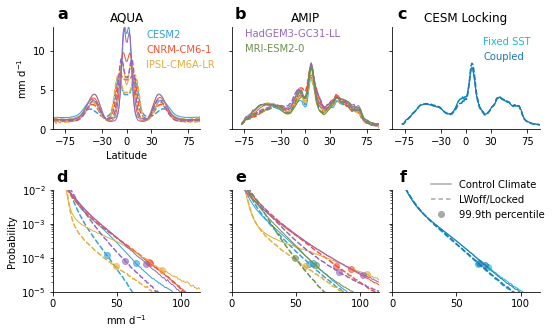

In [17]:

# I want to have 3 columns that show:
# |-- aqua --|-- amip --|-- lock --|

# 2 rows: zonal mean and histogram

fig, axx = plt.subplots(figsize=(mm2inches(190), mm2inches(115)), ncols=3, nrows=2, constrained_layout=True)
# [a.set_prop_cycle('color', palettable.colorbrewer.qualitative.Paired_12.mpl_colors) for a in axx.ravel()]

all_lines = []
line_holder = []  # to customize legend later
labl_holder  = []
ax = axx[0,:]
for m in ZM:
    leglabel = m
    for ex in ZM[m]:
        clr = mc[m][ex]
        xlat = ZM[m][ex]['lat']
        xzm = ZM[m][ex]
        if "aqua" in ex:
            panel = 0
        elif "amip" in ex:
            panel = 1
            labl_holder.append(leglabel)  # holds just the amip labels
        else:
            panel = 2
            leglabel = ex
        if ('lock' in ex) or ('off' in ex):
            linsty = (0, (3,2))
            lw = 1.5
        else:
            linsty = 'solid'
            lw = 1
        all_lines.append(ax[panel].plot(xlat, xzm, label=leglabel, color=clr, linestyle=linsty, linewidth=lw, dash_capstyle = "round"))
        if panel == 1:
            line_holder.append(all_lines[-1][0])
[a.set_xlim([-90, 90]) for a in ax]
[a.set_ylim([0,13]) for a in ax]
[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]
[a.set_yticklabels([]) for i, a in enumerate(ax) if i > 0 ]
[a.set_xticks([-75, -30, 0, 30, 75]) for i, a in enumerate(ax)]
titles = ["AQUA", "AMIP", "CESM Locking"]
[a.set_title(titles[i]) for i, a in enumerate(ax)]
ax[0].set_ylabel("mm d$^{-1}$")
ax[0].set_xlabel("Latitude")



ax = axx[1,:]
for m in H:
    for ex in H[m]:
        clr = mc[m][ex]
        xlat = H[m][ex]['bins']
        y = H[m][ex]
        if "aqua" in ex:
            panel = 0
        elif "amip" in ex:
            panel = 1
        else:
            panel = 2
        if ('lock' in ex) or ('off' in ex):
            linsty = (0, (3, 2))
            lw = 1.5
        else:
            linsty = 'solid'
            lw = 1
        ax[panel].plot(xlat, y, label=m, color=clr, linestyle=linsty, linewidth=lw, dash_capstyle='round')
        # ADD DOT AT SELECTED QUANTILE:
        pct = Q[m][ex].sel(quantile=0.999).item()
        nearest_idx = np.abs(xlat - pct).argmin().item()
        ax[panel].plot(pct, y[nearest_idx], marker='o', color=clr, markersize=6, alpha=0.6)
        print(pct, y[nearest_idx].item())
        
[a.semilogy() for a in axx[1,:]]
[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]
[a.set_ylim([1e-5,1e-2]) for a in ax]
[a.set_xlim([0,115]) for a in ax]
[a.set_yticklabels([]) for i, a in enumerate(ax) if i > 0 ]
ax[0].set_ylabel("Probability")
ax[0].set_xlabel("mm d$^{-1}$")
# ax[-1].text(30, 3e-3, "dots: 99.9th percentile")


leg0 = axx[0,0].legend(line_holder[1:6:2], labl_holder[1:6:2], ncol=1, handlelength=0, frameon=False, loc=(.55, .55))
leg1 = axx[0,1].legend(line_holder[7::2], labl_holder[7::2], ncol=1, handlelength=0,frameon=False, loc=(.01,.7))
# leg1 = axx[0,1].legend(line_holder[1::2], labl_holder[1::2], ncol=2, handlelength=0,frameon=False, loc=(.01,.5))
# # change the font colors to match the line colors:
for line,text in zip(leg0.get_lines(), leg0.get_texts()):
    text.set_color(line.get_color())
for line,text in zip(leg1.get_lines(), leg1.get_texts()):
    text.set_color(line.get_color())


    
# FOR FINAL VERSION ADD PANEL LABELS:
axr = axx.ravel()
for i, label in enumerate(('a', 'b', 'c', 'd', 'e', 'f')):
    addto = axr[i]
    addto.text(0.1, 1.2, label, transform=addto.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')



# leg2 = axx[0,-1].legend(handlelength=0,frameon=False, ncol=2)
# # change the font colors to match the line colors:
# for line,text in zip(leg2.get_lines(), leg2.get_texts()):
#     text.set_color(line.get_color())
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker="None", linestyle="None", color=model_colors['f-cntl'], label='Fixed SST'),
                   Line2D([0], [0], marker="None", linestyle="None", color=model_colors['c-cntl'], label='Coupled'),                   
                  ]

axx[0,-1].legend(handles=legend_elements, loc='upper right', labelcolor='linecolor', frameon=False)

# A key in the final axes:
legend_elements_last = [Line2D([0], [0], marker="None", linestyle="solid", color="darkgray", label='Control Climate'),
                        Line2D([0], [0], marker="None", linestyle=linsty, color="darkgray", label='LWoff/Locked'),                                      
                        Line2D([0], [0], marker="o", linestyle="None", color="darkgray", label='99.9th percentile'),                   
                  ]


# axx[-1,-1].legend(handles=legend_elements_last, loc='upper right', bbox_to_anchor=(1.1, 1.2), frameon=False)
fig.legend(handles=legend_elements_last, loc='upper right', bbox_to_anchor=(1.02, 0.49), frameon=False)


# fig.suptitle(region_string)
# fig.savefig(f"/Users/brianpm/Dropbox/Apps/Overleaf/cre_pex/amip_aqua_locking_zonal_and_pdf_{region_string}_withHadGEM.pdf", bbox_inches='tight')
fig.savefig(f"/Users/brianpm/Dropbox/Apps/Overleaf/cre_pex/Figure_1_final.pdf", bbox_inches='tight')

In [36]:
palettable.colorbrewer.qualitative.Paired_12.mpl_colors

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [13]:
for m in ZM:
    for x in ZM[m]:
        print(f"{m} - {x} max zonal mean precip: {ZM[m][x].max().values.item()}")

CESM2 - aqua-control max zonal mean precip: 13.127031326293945
CESM2 - aqua-control-lwoff max zonal mean precip: 6.690202713012695
CESM2 - amip max zonal mean precip: 6.647918224334717
CESM2 - amip-lwoff max zonal mean precip: 6.874088287353516
CESM2 - f-cntl max zonal mean precip: 7.656839847564697
CESM2 - f-lock max zonal mean precip: 7.842916011810303
CESM2 - c-cntl max zonal mean precip: 7.895636558532715
CESM2 - c-lock max zonal mean precip: 8.400175094604492
CNRM-CM6-1 - aqua-control max zonal mean precip: 9.738348960876465
CNRM-CM6-1 - aqua-control-lwoff max zonal mean precip: 6.883748531341553
CNRM-CM6-1 - amip max zonal mean precip: 7.992019176483154
CNRM-CM6-1 - amip-lwoff max zonal mean precip: 7.850989818572998
IPSL-CM6A-LR - aqua-control max zonal mean precip: 8.468186378479004
IPSL-CM6A-LR - aqua-control-lwoff max zonal mean precip: 6.9351277351379395
IPSL-CM6A-LR - amip max zonal mean precip: 7.564851760864258
IPSL-CM6A-LR - amip-lwoff max zonal mean precip: 6.5155344009